In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import importlib

from astroLuSt.physics import asteroseismology
from astroLuSt.physics import photometry as alpp
from astroLuSt.synthetics import images as alsi

importlib.reload(asteroseismology)
importlib.reload(alpp)
importlib.reload(alsi)

# Magnitudes and Fluxes

In [ ]:
m = 10
m_ref = 5
f_ref = 2
d = 20 #pc
plx = 1/d #arcsec

## Converting Magnitudes and Fluxes

In [ ]:
f = alpp.mags2fluxes(m=m, m_ref=m_ref, f_ref=5)
print(f'Flux from mags: {f}')
m = alpp.fluxes2mags(f=f, f_ref=f_ref, m_ref=m_ref)
print(f'Mag from fluxes: {m} mag')

## Distance Modulus

In [ ]:
DM = alpp.DistanceModule(m=m, M=None, d=d, plx=None)

print(DM)



## Converting to Wesenheit Magnitude

In [ ]:
W = alpp.wesenheit_magnitude(M=DM.M, CI=0.3, R=0)
print(f'Wesenheit Magnitude: {W} mag')

## Adding Magnitudes and Estimating Target Star Contribution

### Generate some "stars" on a "sky background" (driven by fluxes)

TPF(
    size=(100, 100),
    mode='flux',
    f_ref=1, m_ref=0,
    store_stars=True,
    verbose=0,
)


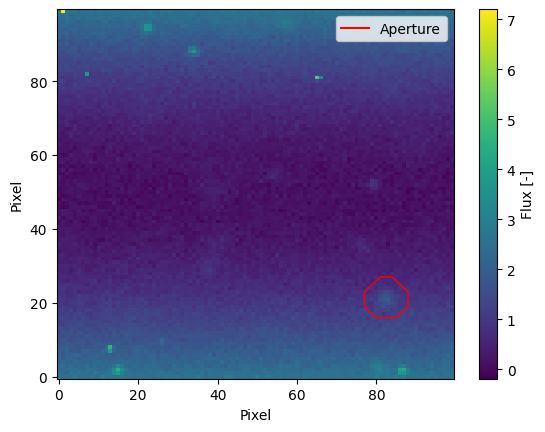

Estimated Aperture: 5


In [699]:
importlib.reload(alsi)


TPF = alsi.TPF(
    size=100,
    mode='flux',
    # mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng=None,
    verbose=0,
)
print(TPF)


TPF.add_stars(
    nstars=50,
    posx={'dist':'uniform', 'params':{'low':0,'high':100}},
    posy={'dist':'uniform', 'params':{'low':0,'high':100}},
    f={'dist':'uniform', 'params':{'low':1,'high':10}},
    # m={'dist':'uniform', 'params':{'low':-4,'high':4}},
    aperture={'dist':'uniform', 'params':{'low':1,'high':20}},
)
# TPF.add_stars(
#     nstars=10,
#     posx={'dist':'uniform', 'params':[0,100]},
#     posy={'dist':'uniform', 'params':[0,100]},
#     f={'dist':'uniform', 'params':[1,100]},
# )
# TPF.add_stars(
#     nstars=25,
#     posx=np.array([50, 90]),
#     posy=np.array([50, 20]),
#     f=np.array([2000, 1000]),
#     m=np.array([-5, 0]),
#     aperture=np.array([4, 1]),
#     # f={'dist':'uniform', 'params':{'low':1,'high':100}},
#     # m={'dist':'uniform', 'params':{'low':-4,'high':4}},
#     # aperture={'dist':'uniform', 'params':{'low':1,'high':2}},    
# )
# TPF.add_stars(random={'nstars':50, 'fmin':100, 'fmax':1000, 'apmin':10, 'apmax':20})
# TPF.add_stars(random=False, pos=np.array([[50,50]]), f=[2000], aperture=[10])   #target star at defined position and with defined luminosity
TPF.add_custom(np.linspace(-50,np.ones((100))*50,100)**2, amplitude=1E-3)       #quadratic trend
TPF.add_noise(amp=1E-1, bias=1E-1)

fig, axs = TPF.plot_result(plot_apertures=[-1])
plt.show()

#estimate aperture
try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,1]):.0f}')
except:
    pass

### Generate some "stars" on a "sky background" (driven by magnitudes)

In [ ]:
importlib.reload(alsi)


TPF = alsi.TPF(
    size=100,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    verbose=0
)
print(TPF)


TPF.add_stars(random={'nstars':50,'mmin':5, 'mmax':8, 'apmin':5,  'apmax':10,  'posx_res':100, 'posy_res':100})
TPF.add_stars(random={'nstars':1, 'mmin':0, 'mmax':3, 'apmin':10, 'apmax':15, 'posx':(25,75), 'posy':(25,75)})
TPF.add_noise(amp=5E-5, bias=1E-5)
TPF.add_custom(trend='lineary', amplitude=2E-4)       #use preset trend

# fig, axs = TPF.plot_result(plot_apertures=[-1])
fig, axs = TPF.plot_result(plot_apertures=[-1], pcolormesh_kwargs=dict(vmin=6, vmax=9))

try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,1]):.0f}')
except:
    pass
print(TPF.starparams[-1])

In [ ]:
nstars = 100
npixels = 50
mag_range = 10
poss = np.random.random_integers(0, npixels-1, size=(nstars,2))
mags = np.random.random_integers(0-mag_range/2, 0+mag_range/2, size=(nstars,1))
stars = np.append(poss, mags, axis=1)

#generate target star
star_targ = np.array([npixels//2,npixels//2, -10])

#sky background
obs = np.zeros((npixels,npixels)) + 20

#add stars of different magnitude
obs[stars[:,0],stars[:,1]] = stars[:,2].flatten()

#add target star
obs[star_targ[0], star_targ[1]] = star_targ[2]



fig = plt.figure()
ax1 = fig.add_subplot(111)
mesh = ax1.pcolormesh(obs, cmap='viridis_r')
ax1.scatter(*star_targ[:2]+.5, marker='x', c='r', label='Target')

ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')

cbar = fig.colorbar(mesh, ax=ax1)
cbar.ax.invert_yaxis()
cbar.ax.set_ylim(0-mag_range/2-1)
cbar.set_label('Magnitude [mag]')

ax1.legend()

plt.show()

Calculate total magnitude of generated (contaminant) stars, weighted by distance to target star.

In [ ]:
#calculate distances
dists = np.sqrt(np.sum((stars[:,:2] - star_targ[:2])**2, axis=1))
w = dists/dists.max()   #normalize distances to a max of

m_tot = alpp.mags_sum(m=stars[:,2], w=w)
print(f'Total magnitude of contaminants: {m_tot:.5f} mag')


Calculate fractional contribution of the target star (single target)

In [ ]:

m_cont_pre = alpp.mags_contribution(m=star_targ[2], m_cont=m_tot)           #using calculated total magnitude
m_cont_fly = alpp.mags_contribution(m=star_targ[2], m_cont=stars[:,2], w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (precalculated): {m_cont_pre:.3f}')
print(f'Contribution of Target (on the fly):    {m_cont_fly:.3f}')


Calculate fractional contribution of the target stars (multiple)

In [ ]:

multi = np.array([star_targ[2], star_targ[2]/2])

m_cont_fly = alpp.mags_contribution(m=multi, m_cont=stars[:,2], w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (on the fly): {m_cont_fly}')


# Asteroseismic Scaling Relations

See for example [Gaulme et al., (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..121G/abstract) and references therein.

In [ ]:
SR = asteroseismology.ScalingRelations(
    nu_max  =np.array([3100,  1573, 1354]),
    delta_nu=np.array([135.2, 80.62, 73.22]),
    t_eff   =np.array([5777,  6433, 5645]),
    e_nu_max=np.array([np.nan, 11, 30]),
    e_delta_nu=np.array([np.nan, 1.88, 2.13]),
    e_t_eff=np.array([np.nan, 80, 80]),
    zeta_corr=False
)
print(SR)

mass = SR.get_mass()
radius = SR.get_radius()
logg = SR.get_logg()
logL = SR.get_luminosity()

df = SR.results2pandas()

df